In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.special import logsumexp

# Utility Functions

In [2]:
def euclidean_distance(x1, x2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def normalize_features(X_train, X_test):
    """Z-score normalization of features"""
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1e-10  # Avoid division by zero

    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    return X_train_norm, X_test_norm

def evaluate(y_true, y_pred):
    """Calculate accuracy score"""
    return np.sum(y_true == y_pred) / len(y_true)

def enhanced_map_clusters_to_speakers(cluster_labels, true_labels):
    """Advanced mapping from clusters to speaker labels"""
    unique_clusters = np.unique(cluster_labels)
    unique_speakers = np.unique(true_labels)

    # Calculate confusion matrix between clusters and speakers
    confusion = np.zeros((len(unique_clusters), len(unique_speakers)))
    
    # Make sure we only consider samples where both labels are available
    # This handles the case when cluster_labels and true_labels have different shapes
    if len(cluster_labels) != len(true_labels):
        min_len = min(len(cluster_labels), len(true_labels))
        cluster_labels = cluster_labels[:min_len]
        true_labels = true_labels[:min_len]
        print(f"Warning: Truncated labels to match length: {min_len}")
    
    for i, cluster in enumerate(unique_clusters):
        for j, speaker in enumerate(unique_speakers):
            confusion[i, j] = np.sum((cluster_labels == cluster) & (true_labels == speaker))

    purity = np.zeros(len(unique_clusters))
    mapping = {}

    # First pass: assign high-confidence mappings
    assigned_speakers = set()
    for i, cluster in enumerate(unique_clusters):
        cluster_sum = np.sum(confusion[i])
        if cluster_sum > 0:
            purity[i] = np.max(confusion[i]) / cluster_sum
            if purity[i] >= 0.7:
                speaker_idx = np.argmax(confusion[i])
                speaker = unique_speakers[speaker_idx]
                mapping[cluster] = speaker
                assigned_speakers.add(speaker)

    # Second pass: assign remaining clusters
    for i, cluster in enumerate(unique_clusters):
        if cluster not in mapping:
            cluster_sum = np.sum(confusion[i])
            if cluster_sum > 0:
                # Get top speaker candidates
                top_indices = np.argsort(-confusion[i])[:3]

                # Try to assign to unassigned speakers first
                assigned = False
                for idx in top_indices:
                    speaker = unique_speakers[idx]
                    if speaker not in assigned_speakers and confusion[i, idx] > 0:
                        mapping[cluster] = speaker
                        assigned_speakers.add(speaker)
                        assigned = True
                        break

                if not assigned:
                    speaker_idx = np.argmax(confusion[i])
                    mapping[cluster] = unique_speakers[speaker_idx]
            else:
                mapping[cluster] = unique_speakers[0]

    # Map prediction labels
    mapped_labels = np.array([mapping[label] for label in cluster_labels])
    print(f"Average cluster purity: {np.mean(purity):.4f}")

    return mapped_labels

def calculate_cluster_purity(cluster_labels, true_labels):
    """Calculate purity for each cluster"""
    unique_clusters = np.unique(cluster_labels)
    unique_speakers = np.unique(true_labels)

    # Calculate confusion matrix
    confusion = np.zeros((len(unique_clusters), len(unique_speakers)))
    for i, cluster in enumerate(unique_clusters):
        for j, speaker in enumerate(unique_speakers):
            confusion[i, j] = np.sum((cluster_labels == cluster) & (true_labels == speaker))

    # Calculate purity for each cluster
    cluster_purities = {}
    cluster_sizes = {}

    for i, cluster in enumerate(unique_clusters):
        cluster_sum = np.sum(confusion[i])
        if cluster_sum > 0:
            purity = np.max(confusion[i]) / cluster_sum
            cluster_purities[cluster] = purity
            cluster_sizes[cluster] = cluster_sum

    return cluster_purities, cluster_sizes, confusion

# Add a new preprocessing function for better feature transformation
def advanced_preprocess(X_train, X_val, X_test, n_components=None, use_power_transform=True):
    """Advanced preprocessing pipeline for features"""
    # Apply power transform (Yeo-Johnson) to make data more Gaussian-like
    if use_power_transform:
        power = PowerTransformer(method='yeo-johnson')
        X_train_trans = power.fit_transform(X_train)
        X_val_trans = power.transform(X_val) if X_val is not None else None
        X_test_trans = power.transform(X_test) if X_test is not None else None
    else:
        X_train_trans, X_val_trans, X_test_trans = X_train, X_val, X_test
    
    # Apply PCA if n_components is specified
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train_trans = pca.fit_transform(X_train_trans)
        X_val_trans = pca.transform(X_val_trans) if X_val_trans is not None else None
        X_test_trans = pca.transform(X_test_trans) if X_test_trans is not None else None
        print(f"PCA explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
    
    # Standard normalization
    mean = np.mean(X_train_trans, axis=0)
    std = np.std(X_train_trans, axis=0)
    std[std < 1e-10] = 1e-10  # Avoid division by zero
    
    X_train_norm = (X_train_trans - mean) / std
    X_val_norm = (X_val_trans - mean) / std if X_val_trans is not None else None
    X_test_norm = (X_test_trans - mean) / std if X_test_trans is not None else None
    
    return X_train_norm, X_val_norm, X_test_norm

# GMM Visualization Functions

In [3]:
def plot_gmm_bic_values(n_components_range, bic_values, optimal_n):
    """Plot BIC values for different numbers of components"""
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic_values, 'o-', linewidth=2, markersize=8)
    plt.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal n={optimal_n}')
    plt.xlabel('Number of Components (n)', fontsize=12)
    plt.ylabel('BIC', fontsize=12)
    plt.title('BIC for Determining Optimal Number of Components', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_validation_accuracy(n_components_range, val_accuracies, optimal_n, train_accuracies=None, test_accuracies=None):
    """Plot validation accuracy for different numbers of components"""
    plt.figure(figsize=(10, 6))
    
    # Plot validation accuracy
    plt.plot(n_components_range, val_accuracies, 'o-', color='green', label='Validation Accuracy')
    
    # Plot training accuracy if provided
    if train_accuracies is not None:
        plt.plot(n_components_range, train_accuracies, 's-', color='blue', label='Training Accuracy')
    
    # Plot testing accuracy if provided
    if test_accuracies is not None:
        plt.plot(n_components_range, test_accuracies, '^-', color='red', label='Testing Accuracy')
    
    plt.axvline(x=optimal_n, color='black', linestyle='--', label=f'Optimal n={optimal_n}')
    plt.xlabel('Number of Components (n)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'Accuracy vs n (Best Val: {max(val_accuracies):.4f} at n={optimal_n})', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix between true and predicted labels"""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Get unique speaker IDs
    unique_speakers = np.unique(np.concatenate([y_true, y_pred]))
    n_speakers = len(unique_speakers)
    
    # If there are too many speakers, limit to the top 20
    if n_speakers > 20:
        # Count occurrences of each speaker
        speaker_counts = {}
        for speaker in unique_speakers:
            speaker_counts[speaker] = np.sum(y_true == speaker)
        
        # Sort speakers by frequency
        top_speakers = sorted(speaker_counts.keys(), key=lambda k: speaker_counts[k], reverse=True)[:20]
        
        # Filter data to only include top speakers
        mask = np.isin(y_true, top_speakers)
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]
        
        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_speakers)
        speakers = top_speakers
    else:
        cm = confusion_matrix(y_true, y_pred, labels=unique_speakers)
        speakers = unique_speakers
    
    # Create a normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=False, cmap="YlGnBu", vmin=0, vmax=1)
    plt.xlabel('Predicted Speaker', fontsize=12)
    plt.ylabel('True Speaker', fontsize=12)
    plt.title(title, fontsize=14)
    
    # If there are many speakers, show tick labels for every 5th speaker
    if len(speakers) > 10:
        tick_indices = np.arange(0, len(speakers), 5)
        plt.xticks(tick_indices + 0.5, [f"S{speakers[i]}" for i in tick_indices], rotation=45)
        plt.yticks(tick_indices + 0.5, [f"S{speakers[i]}" for i in tick_indices])
    else:
        plt.xticks(np.arange(len(speakers)) + 0.5, [f"S{s}" for s in speakers], rotation=45)
        plt.yticks(np.arange(len(speakers)) + 0.5, [f"S{s}" for s in speakers])
    
    plt.tight_layout()
    plt.show()

def plot_per_speaker_accuracy(y_true, y_pred, title="Per-Speaker Accuracy"):
    """Plot accuracy for each individual speaker"""
    # Get unique speakers
    unique_speakers = np.unique(y_true)
    
    # Calculate accuracy for each speaker
    speaker_accuracies = {}
    speaker_counts = {}
    
    for speaker in unique_speakers:
        mask = (y_true == speaker)
        if np.sum(mask) > 0:
            speaker_accuracies[speaker] = np.mean(y_pred[mask] == speaker)
            speaker_counts[speaker] = np.sum(mask)
    
    # Sort speakers by count (frequency)
    sorted_speakers = sorted(speaker_accuracies.keys(), 
                            key=lambda k: speaker_counts[k], 
                            reverse=True)
    
    # Limit to top 30 speakers if there are many
    if len(sorted_speakers) > 30:
        sorted_speakers = sorted_speakers[:30]
    
    accuracies = [speaker_accuracies[s] for s in sorted_speakers]
    counts = [speaker_counts[s] for s in sorted_speakers]
    
    # Plot accuracies
    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(sorted_speakers)), accuracies, color='skyblue')
    
    # Color bars by accuracy
    for i, acc in enumerate(accuracies):
        if acc >= 0.9:
            bars[i].set_color('darkgreen')
        elif acc >= 0.7:
            bars[i].set_color('yellowgreen')
        elif acc >= 0.5:
            bars[i].set_color('orange')
        else:
            bars[i].set_color('salmon')
    
    # Add count annotations
    for i, (acc, count) in enumerate(zip(accuracies, counts)):
        plt.annotate(f'{count}', xy=(i, acc+0.02), ha='center', fontsize=9)
    
    plt.xlabel('Speaker ID', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(range(len(sorted_speakers)), [f'S{s}' for s in sorted_speakers], rotation=90)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_cluster_purity(cluster_purities, cluster_sizes, n_components, title="Cluster Purity Analysis"):
    """
    Plot purity values for each cluster
    
    Parameters:
    - cluster_purities: Dictionary mapping cluster ID to purity value
    - cluster_sizes: Dictionary mapping cluster ID to cluster size
    - n_components: Number of components/clusters
    - title: Plot title
    """
    plt.figure(figsize=(14, 6))
    
    # Sort clusters by size
    sorted_clusters = sorted(cluster_purities.keys(), 
                           key=lambda k: cluster_sizes.get(k, 0), 
                           reverse=True)
    
    # Get purity and size values
    purities = [cluster_purities.get(c, 0) for c in sorted_clusters]
    sizes = [cluster_sizes.get(c, 0) for c in sorted_clusters]
    
    # Normalize sizes for better visualization
    max_size = max(sizes)
    norm_sizes = [0.3 + 0.7 * (s / max_size) for s in sizes]
    
    # Plot purities
    bars = plt.bar(range(len(sorted_clusters)), purities, 
                 width=norm_sizes, alpha=0.7, color='skyblue')
    
    # Color bars by purity
    for i, purity in enumerate(purities):
        if purity >= 0.9:
            bars[i].set_color('darkgreen')
        elif purity >= 0.7:
            bars[i].set_color('yellowgreen')
        elif purity >= 0.5:
            bars[i].set_color('orange')
        else:
            bars[i].set_color('salmon')
    
    # Add size annotations
    for i, (purity, size) in enumerate(zip(purities, sizes)):
        plt.annotate(f'{size}', xy=(i, purity+0.03), ha='center', fontsize=9)
    
    # Add mean purity line
    mean_purity = np.mean(list(cluster_purities.values()))
    plt.axhline(y=mean_purity, color='red', linestyle='--', 
               label=f'Mean Purity: {mean_purity:.3f}')
    
    plt.xlabel('Cluster ID (sorted by size)', fontsize=12)
    plt.ylabel('Purity', fontsize=12)
    plt.title(f"{title} (n={n_components})", fontsize=14)
    plt.xticks(range(len(sorted_clusters)), [f'C{c}' for c in sorted_clusters], rotation=90)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_likelihood_convergence(log_likelihoods):
    """Plot the convergence of log-likelihoods during GMM training"""
    plt.figure(figsize=(10, 6))
    plt.plot(log_likelihoods, 'o-', linewidth=2, color='blue')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Log-Likelihood', fontsize=12)
    plt.title('GMM Convergence: Log-Likelihood vs. Iteration', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_cluster_embeddings(X, labels, method='pca', title="Cluster Visualization"):
    """
    Visualize clusters in 2D space using dimensionality reduction
    
    Parameters:
    - X: Feature matrix
    - labels: Cluster assignments
    - method: 'pca' or 'tsne'
    - title: Plot title
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Reduce dimensionality to 2D for visualization
    if method == 'tsne':
        from sklearn.manifold import TSNE
        print("Applying t-SNE for visualization...")
        X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)
        method_name = "t-SNE"
    else:
        # Default to PCA
        from sklearn.decomposition import PCA
        print("Applying PCA for visualization...")
        X_2d = PCA(n_components=2, random_state=42).fit_transform(X)
        method_name = "PCA"
    
    # Create scatter plot with clusters
    plt.figure(figsize=(12, 10))
    
    # Define colormap
    cmap = plt.cm.get_cmap('tab20', n_clusters)
    
    # Plot each cluster
    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                   c=[cmap(i)], label=f'Cluster {label}',
                   alpha=0.7, s=30, edgecolors='k', linewidths=0.5)
    
    # If there aren't too many clusters, show legend
    if n_clusters <= 20:
        plt.legend(fontsize=10, markerscale=2, loc='best')
    
    plt.xlabel(f'{method_name} Component 1', fontsize=12)
    plt.ylabel(f'{method_name} Component 2', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# GMM Implementation

In [4]:
class GaussianMixtureModel:
    """Enhanced Gaussian Mixture Model implementation for speaker recognition"""
    
    def __init__(self, max_iters=100, tol=1e-4, reg_covar=1e-6, covariance_type='full', 
                 init_method='kmeans++', semi_supervised=False, supervision_weight=0.5):
        self.max_iters = max_iters
        self.tol = tol  # convergence threshold
        self.reg_covar = reg_covar  # regularization parameter for covariance matrices
        self.weights = None  # mixture weights
        self.means = None    # component means
        self.covars = None   # component covariance matrices
        self.n_components = None
        self.covariance_type = covariance_type  # 'full', 'diagonal', 'tied', or 'spherical'
        self.init_method = init_method  # 'random', 'kmeans++', or 'kmeans'
        self.semi_supervised = semi_supervised  # whether to use semi-supervised learning
        self.supervision_weight = supervision_weight  # weight for known labels in semi-supervised learning
        self.label_to_component_map = None  # mapping from labels to components for semi-supervised learning
        
    def _initialize_parameters(self, X, n_components, y=None):
        """Initialize GMM parameters with improved strategies"""
        n_samples, n_features = X.shape
        self.n_components = n_components
        
        # Initialize means
        if self.init_method == 'random':
            # Random initialization
            indices = np.random.choice(n_samples, n_components, replace=False)
            self.means = X[indices]
        elif self.init_method == 'kmeans++' or self.init_method == 'kmeans':
            # KMeans/KMeans++ initialization
            kmeans = KMeans(n_clusters=n_components, init='k-means++', n_init=10)
            kmeans.fit(X)
            self.means = kmeans.cluster_centers_
        
        # Initialize covariances based on covariance type
        if self.covariance_type == 'full':
            # Full covariance matrices
            self.covars = np.array([np.cov(X.T) + self.reg_covar * np.eye(n_features)] * n_components)
        elif self.covariance_type == 'diagonal':
            # Diagonal covariance matrices
            variance = np.var(X, axis=0)
            self.covars = np.array([np.diag(variance + self.reg_covar)] * n_components)
        elif self.covariance_type == 'tied':
            # Tied covariance matrix (shared across components)
            self.covars = np.cov(X.T) + self.reg_covar * np.eye(n_features)
        elif self.covariance_type == 'spherical':
            # Spherical covariance matrices
            variance = np.mean(np.var(X, axis=0))
            self.covars = np.array([variance * np.eye(n_features)] * n_components)
            
        # Initialize weights uniformly
        self.weights = np.ones(n_components) / n_components
        
        # Setup semi-supervised learning if enabled
        if self.semi_supervised and y is not None:
            self._setup_semi_supervised(X, y)
            
    def _setup_semi_supervised(self, X, y):
        """Setup for semi-supervised learning"""
        # Create a mapping from class labels to component indices
        unique_labels = np.unique(y)
        n_labels = len(unique_labels)
        
        # If we have more components than labels, assign multiple components per label
        if self.n_components >= n_labels:
            components_per_label = self.n_components // n_labels
            self.label_to_component_map = {}
            
            component_idx = 0
            for label in unique_labels:
                self.label_to_component_map[label] = []
                for _ in range(components_per_label):
                    if component_idx < self.n_components:
                        self.label_to_component_map[label].append(component_idx)
                        component_idx += 1
                        
            # Assign any remaining components
            remaining_label = 0
            while component_idx < self.n_components:
                self.label_to_component_map[unique_labels[remaining_label]].append(component_idx)
                component_idx += 1
                remaining_label = (remaining_label + 1) % n_labels
                
            # Initialize means for each label's components using samples from that label
            for label, components in self.label_to_component_map.items():
                label_samples = X[y == label]
                n_label_samples = len(label_samples)
                
                if n_label_samples >= len(components):
                    # If we have enough samples, use k-means++ to initialize
                    kmeans = KMeans(n_clusters=len(components), init='k-means++', n_init=3)
                    kmeans.fit(label_samples)
                    
                    for i, comp_idx in enumerate(components):
                        self.means[comp_idx] = kmeans.cluster_centers_[i]
                else:
                    # If we don't have enough samples, use what we have
                    for i, comp_idx in enumerate(components):
                        if i < n_label_samples:
                            self.means[comp_idx] = label_samples[i]
        else:
            # If we have fewer components than labels, assign one component to each label
            # until we run out of components
            self.label_to_component_map = {}
            for i, label in enumerate(unique_labels[:self.n_components]):
                self.label_to_component_map[label] = [i]
                
                # Initialize mean using samples from this label
                label_samples = X[y == label]
                if len(label_samples) > 0:
                    self.means[i] = np.mean(label_samples, axis=0)
        
    def _e_step(self, X, y=None):
        """E-step: Compute responsibilities (posterior probabilities)"""
        n_samples = X.shape[0]
        
        # Calculate likelihoods
        weighted_log_prob = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # Calculate log probability based on covariance type
            try:
                if self.covariance_type == 'full':
                    dist = multivariate_normal(mean=self.means[k], cov=self.covars[k])
                    log_prob = dist.logpdf(X)
                elif self.covariance_type == 'diagonal':
                    # Use diagonal covariance
                    if isinstance(self.covars, list):
                        cov_diag = np.diag(self.covars[k])
                    else:
                        cov_diag = np.diag(self.covars[k])
                    log_prob = self._log_multivariate_normal_density_diag(X, self.means[k], cov_diag)
                elif self.covariance_type == 'tied':
                    # Use shared covariance matrix
                    dist = multivariate_normal(mean=self.means[k], cov=self.covars)
                    log_prob = dist.logpdf(X)
                elif self.covariance_type == 'spherical':
                    # Use spherical covariance
                    if isinstance(self.covars, list):
                        variance = self.covars[k][0, 0]  # Get the variance from the first element
                    else:
                        variance = self.covars[k]
                    log_prob = self._log_multivariate_normal_density_spherical(X, self.means[k], variance)
                
                weighted_log_prob[:, k] = log_prob + np.log(self.weights[k])
            except Exception as e:
                print(f"Error in E-step for component {k}: {e}")
                # Fallback to a "safe" calculation with diagonal covariance
                cov_diag = np.diag(np.diag(self.covars[k] if self.covariance_type != 'tied' else self.covars))
                cov_diag = cov_diag + self.reg_covar * np.eye(X.shape[1])
                log_prob = self._log_multivariate_normal_density_diag(X, self.means[k], cov_diag)
                weighted_log_prob[:, k] = log_prob + np.log(self.weights[k])
        
        # Compute log likelihood and responsibilities
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        resp = np.exp(log_resp)
        
        # Adjust responsibilities for semi-supervised learning
        if self.semi_supervised and y is not None and self.label_to_component_map is not None:
            resp = self._adjust_responsibilities_semi_supervised(resp, y)
            
        return resp, np.sum(log_prob_norm)
    
    def _log_multivariate_normal_density_diag(self, X, mean, diag_cov):
        """Compute log probability under a multivariate Gaussian with diagonal covariance"""
        n_samples, n_dim = X.shape
        
        # Add small regularization to avoid numerical issues
        diag_cov = np.maximum(diag_cov, self.reg_covar)
        
        log_det = np.sum(np.log(diag_cov))
        precisions = 1.0 / diag_cov
        
        # Compute log probability
        log_prob = -0.5 * (n_dim * np.log(2 * np.pi) + log_det)
        for i in range(n_samples):
            diff = X[i] - mean
            log_prob_i = log_prob - 0.5 * np.sum(diff ** 2 * precisions)
            if i == 0:
                log_probs = np.array([log_prob_i])
            else:
                log_probs = np.append(log_probs, log_prob_i)
                
        return log_probs
    
    def _log_multivariate_normal_density_spherical(self, X, mean, variance):
        """Compute log probability under a multivariate Gaussian with spherical covariance"""
        n_samples, n_dim = X.shape
        
        # Add small regularization to avoid numerical issues
        variance = max(variance, self.reg_covar)
        
        log_det = n_dim * np.log(variance)
        precision = 1.0 / variance
        
        # Compute log probability
        log_prob = -0.5 * (n_dim * np.log(2 * np.pi) + log_det)
        log_probs = np.zeros(n_samples)
        
        for i in range(n_samples):
            diff = X[i] - mean
            log_probs[i] = log_prob - 0.5 * precision * np.sum(diff ** 2)
                
        return log_probs
    
    def _adjust_responsibilities_semi_supervised(self, resp, y):
        """Adjust responsibilities based on known labels for semi-supervised learning"""
        modified_resp = resp.copy()
        
        # Get indices where labels are available
        labeled_indices = ~np.isnan(y) if np.issubdtype(y.dtype, np.floating) else y >= 0
        
        for i in np.where(labeled_indices)[0]:
            label = y[i]
            if label in self.label_to_component_map:
                # Get components associated with this label
                label_components = self.label_to_component_map[label]
                
                # Create a mask for components that don't belong to this label
                mask = np.ones(self.n_components, dtype=bool)
                mask[label_components] = False
                
                # Apply supervision weight: reduce probabilities for non-matching components
                modified_resp[i, mask] *= (1 - self.supervision_weight)
                
                # Normalize to ensure probabilities sum to 1
                modified_resp[i] /= np.sum(modified_resp[i])
                
        return modified_resp
    
    def _m_step(self, X, resp):
        """M-step: Update parameters based on responsibilities"""
        n_samples, n_features = X.shape
        
        # Calculate new weights (mixing coefficients)
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps  # avoid division by zero
        self.weights = nk / n_samples
        
        # Calculate new means
        self.means = np.dot(resp.T, X) / nk[:, np.newaxis]
        
        # Calculate new covariances based on covariance type
        if self.covariance_type == 'full':
            self.covars = np.zeros((self.n_components, n_features, n_features))
            for k in range(self.n_components):
                diff = X - self.means[k]
                weighted_diff = resp[:, k, np.newaxis] * diff
                self.covars[k] = np.dot(diff.T, weighted_diff) / nk[k]
                # Add regularization
                self.covars[k] += self.reg_covar * np.eye(n_features)
                
        elif self.covariance_type == 'diagonal':
            self.covars = np.zeros((self.n_components, n_features))
            for k in range(self.n_components):
                diff = X - self.means[k]
                weighted_diff = resp[:, k, np.newaxis] * diff
                self.covars[k] = np.sum(diff * weighted_diff, axis=0) / nk[k]
                # Add regularization
                self.covars[k] += self.reg_covar
                
        elif self.covariance_type == 'tied':
            self.covars = np.zeros((n_features, n_features))
            for k in range(self.n_components):
                diff = X - self.means[k]
                weighted_diff = resp[:, k, np.newaxis] * diff
                self.covars += np.dot(diff.T, weighted_diff) / n_samples
            # Add regularization
            self.covars += self.reg_covar * np.eye(n_features)
            
        elif self.covariance_type == 'spherical':
            self.covars = np.zeros(self.n_components)
            for k in range(self.n_components):
                diff = X - self.means[k]
                weighted_diff = resp[:, k, np.newaxis] * diff
                self.covars[k] = np.sum(diff * weighted_diff) / (n_features * nk[k])
                # Add regularization
                self.covars[k] += self.reg_covar
            
    def fit(self, X, n_components, y=None, n_init=1):
        """Fit the GMM model to the data, optionally using labels for semi-supervision"""
        best_log_likelihood = -np.inf
        best_params = None
        best_log_likelihoods = None
        
        for init in range(n_init):
            print(f"Initialization {init+1}/{n_init}")
            
            # Initialize parameters
            self._initialize_parameters(X, n_components, y if self.semi_supervised else None)
            
            # Run EM algorithm
            log_likelihoods = []
            prev_log_likelihood = None
            
            for iteration in range(self.max_iters):
                # E-step
                resp, log_likelihood = self._e_step(X, y if self.semi_supervised else None)
                log_likelihoods.append(log_likelihood)
                
                # Check for convergence
                if prev_log_likelihood is not None:
                    change = log_likelihood - prev_log_likelihood
                    if abs(change) < self.tol:
                        print(f"Converged after {iteration+1} iterations")
                        break
                
                prev_log_likelihood = log_likelihood
                
                # M-step
                self._m_step(X, resp)
            
            # Save best parameters
            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                
                # Copy parameters based on covariance type
                if self.covariance_type == 'full' or self.covariance_type == 'diagonal':
                    best_params = (self.weights.copy(), self.means.copy(), self.covars.copy())
                elif self.covariance_type == 'tied':
                    best_params = (self.weights.copy(), self.means.copy(), self.covars.copy())
                elif self.covariance_type == 'spherical':
                    best_params = (self.weights.copy(), self.means.copy(), self.covars.copy())
                
                best_log_likelihoods = log_likelihoods
                
        # Set the best parameters
        self.weights, self.means, self.covars = best_params
        
        # Get final responsibilities and cluster assignments
        resp, _ = self._e_step(X, y if self.semi_supervised else None)
        labels = resp.argmax(axis=1)
        
        return labels, best_log_likelihoods
    
    def predict(self, X):
        """Predict cluster labels for new data"""
        resp, _ = self._e_step(X)
        return resp.argmax(axis=1)
    
    def predict_proba(self, X):
        """Predict probability of each component for new data"""
        resp, _ = self._e_step(X)
        return resp
    
    def calculate_bic(self, X):
        """Calculate Bayesian Information Criterion (BIC)"""
        n_samples, n_features = X.shape
        
        # Number of free parameters depends on covariance type
        if self.covariance_type == 'full':
            n_params = (self.n_components - 1)  # mixture weights (minus 1 due to sum constraint)
            n_params += self.n_components * n_features  # means
            n_params += self.n_components * n_features * (n_features + 1) // 2  # covariances (assuming symmetric)
        elif self.covariance_type == 'diagonal':
            n_params = (self.n_components - 1)  # mixture weights
            n_params += self.n_components * n_features  # means
            n_params += self.n_components * n_features  # diagonal covariances
        elif self.covariance_type == 'tied':
            n_params = (self.n_components - 1)  # mixture weights
            n_params += self.n_components * n_features  # means
            n_params += n_features * (n_features + 1) // 2  # shared covariance
        elif self.covariance_type == 'spherical':
            n_params = (self.n_components - 1)  # mixture weights
            n_params += self.n_components * n_features  # means
            n_params += self.n_components  # variances
        
        # Log-likelihood
        _, log_likelihood = self._e_step(X)
        
        # BIC = -2 * log-likelihood + n_params * log(n_samples)
        bic = -2 * log_likelihood + n_params * np.log(n_samples)
        
        return bic

In [5]:
class EnsembleGMM:
    """Ensemble of Gaussian Mixture Models for better stability and accuracy"""
    
    def __init__(self, n_estimators=5, max_iters=100, tol=1e-4, reg_covar=1e-6,
                 covariance_types=None, supervision_weight=0.5, semi_supervised=False):
        self.n_estimators = n_estimators
        self.max_iters = max_iters
        self.tol = tol
        self.reg_covar = reg_covar
        self.models = []
        self.covariance_types = covariance_types or ['full', 'diagonal']
        self.semi_supervised = semi_supervised
        self.supervision_weight = supervision_weight
        
    def fit(self, X, n_components, y=None, n_init=3):
        """Fit ensemble of GMM models"""
        self.models = []
        
        # Create a mix of different GMM models
        for i in range(self.n_estimators):
            # Cycle through covariance types
            cov_type = self.covariance_types[i % len(self.covariance_types)]
            
            # Create and fit GMM model
            print(f"\nTraining ensemble member {i+1}/{self.n_estimators} with covariance_type='{cov_type}'")
            gmm = GaussianMixtureModel(
                max_iters=self.max_iters,
                tol=self.tol,
                reg_covar=self.reg_covar,
                covariance_type=cov_type,
                init_method='kmeans++',
                semi_supervised=self.semi_supervised,
                supervision_weight=self.supervision_weight
            )
            
            # Fit the model
            labels, _ = gmm.fit(X, n_components, y=y, n_init=n_init)
            
            # Add model to ensemble
            self.models.append(gmm)
            
        return self
    
    def predict(self, X):
        """Predict using ensemble of GMM models"""
        if not self.models:
            raise ValueError("Models not trained yet. Call fit first.")
        
        # Get predictions from all models
        all_probs = []
        for model in self.models:
            probs = model.predict_proba(X)
            all_probs.append(probs)
        
        # Average probabilities
        avg_probs = np.mean(all_probs, axis=0)
        
        # Return most likely component for each sample
        return np.argmax(avg_probs, axis=1)

# Optimal Components Search

In [6]:
def find_optimal_components(model, X_train, X_val, X_test, y_train, y_val, y_test, n_range, y_train_for_semi=None):
    """Find optimal number of components using validation accuracy and BIC"""
    val_accuracies = []
    train_accuracies = []
    test_accuracies = []
    bic_values = []
    
    for n in n_range:
        print(f"\nTesting n_components = {n}")
        start_time = time.time()
        
        if isinstance(model, EnsembleGMM):
            # Train ensemble model
            model.fit(X_train, n, y=y_train_for_semi)
            # Predict labels
            train_labels = model.predict(X_train)
            val_labels = model.predict(X_val)
            test_labels = model.predict(X_test)
            # No BIC for ensemble
            bic = float('nan')
        else:
            # Train single GMM model
            labels, log_likelihoods = model.fit(X_train, n, y=y_train_for_semi, n_init=3)
            # Calculate BIC
            bic = model.calculate_bic(X_train)
            # Predict validation labels
            train_labels = model.predict(X_train)
            val_labels = model.predict(X_val)
            test_labels = model.predict(X_test)
        
        bic_values.append(bic)
        print(f"BIC: {bic if not np.isnan(bic) else 'N/A'}")
        
        # Map labels and evaluate
        mapped_train_labels = enhanced_map_clusters_to_speakers(train_labels, y_train)
        mapped_val_labels = enhanced_map_clusters_to_speakers(val_labels, y_val)
        mapped_test_labels = enhanced_map_clusters_to_speakers(test_labels, y_test)
        
        # Calculate accuracies
        train_acc = evaluate(y_train, mapped_train_labels)
        val_acc = evaluate(y_val, mapped_val_labels)
        test_acc = evaluate(y_test, mapped_test_labels)
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Testing Accuracy: {test_acc:.4f}")
        print(f"Time taken: {time.time() - start_time:.2f} seconds")
        
    # Get optimal n_components
    optimal_n_idx = np.argmax(val_accuracies)
    optimal_n = n_range[optimal_n_idx]
    
    # Plot validation accuracy with train and test accuracies
    plot_validation_accuracy(n_range, val_accuracies, optimal_n, 
                           train_accuracies=train_accuracies, 
                           test_accuracies=test_accuracies)
    
    # Plot BIC vs n_components if available
    if not np.isnan(bic_values[0]):
        plot_gmm_bic_values(n_range, bic_values, optimal_n)
    
    print(f"\nSelected n_components: {optimal_n} (validation accuracy: {val_accuracies[optimal_n_idx]:.4f})")
    
    return optimal_n, val_accuracies[optimal_n_idx], bic_values


# Main Execution

In [7]:
# Load data
print("Loading data...")
X_lda = np.load('../X_lda.npy')
y_labels = np.load('../y_labels.npy')

# Split data into train/val/test sets
print("Splitting data into train/val/test sets...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_lda, y_labels, test_size=0.3, random_state=43
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=43
)
print(f"Dataset splits: train={X_train.shape[0]}, val={X_val.shape[0]}, test={X_test.shape[0]}")


Loading data...
Splitting data into train/val/test sets...
Dataset splits: train=1405, val=352, test=754


In [8]:
print("Applying advanced preprocessing...")
X_train_norm, X_val_norm, X_test_norm = advanced_preprocess(
    X_train, X_val, X_test, n_components=None, use_power_transform=True
)

# Get number of unique speakers
n_speakers = len(np.unique(y_train))
print(f"Number of unique speakers: {n_speakers}")


Applying advanced preprocessing...
Number of unique speakers: 50



Training semi-supervised GMM...

Testing n_components = 1
Initialization 1/3
Converged after 3 iterations
Initialization 2/3
Converged after 3 iterations
Initialization 3/3
Converged after 3 iterations
BIC: 49663.49786920235
Average cluster purity: 0.0498
Average cluster purity: 0.0682
Average cluster purity: 0.0504
Training Accuracy: 0.0498
Validation Accuracy: 0.0682
Testing Accuracy: 0.0504
Time taken: 0.69 seconds

Testing n_components = 26
Initialization 1/3
Converged after 26 iterations
Initialization 2/3
Converged after 26 iterations
Initialization 3/3
Converged after 26 iterations
BIC: -61143.55099268939
Average cluster purity: 0.7013
Average cluster purity: 0.7429
Average cluster purity: 0.7126
Training Accuracy: 0.5609
Validation Accuracy: 0.6023
Testing Accuracy: 0.5743
Time taken: 8.45 seconds

Testing n_components = 51
Initialization 1/3
Converged after 5 iterations
Initialization 2/3
Converged after 5 iterations
Initialization 3/3
Converged after 6 iterations
BIC: 141989

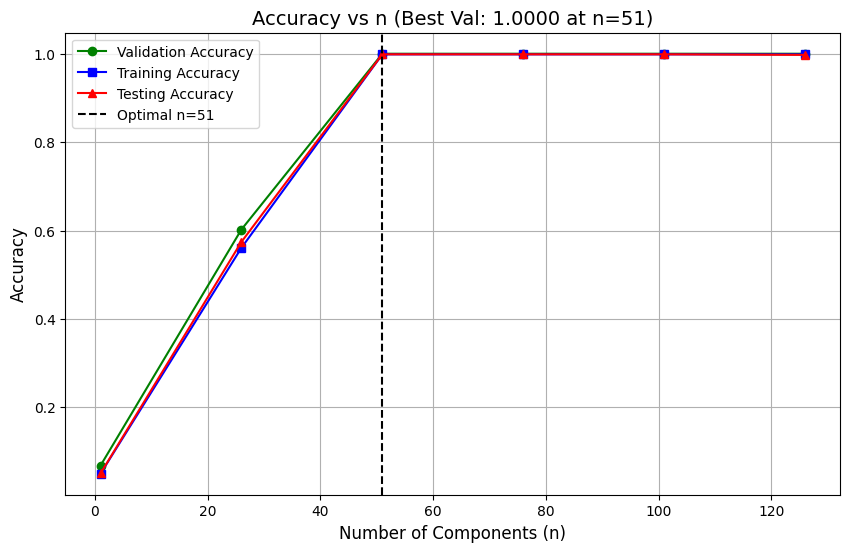

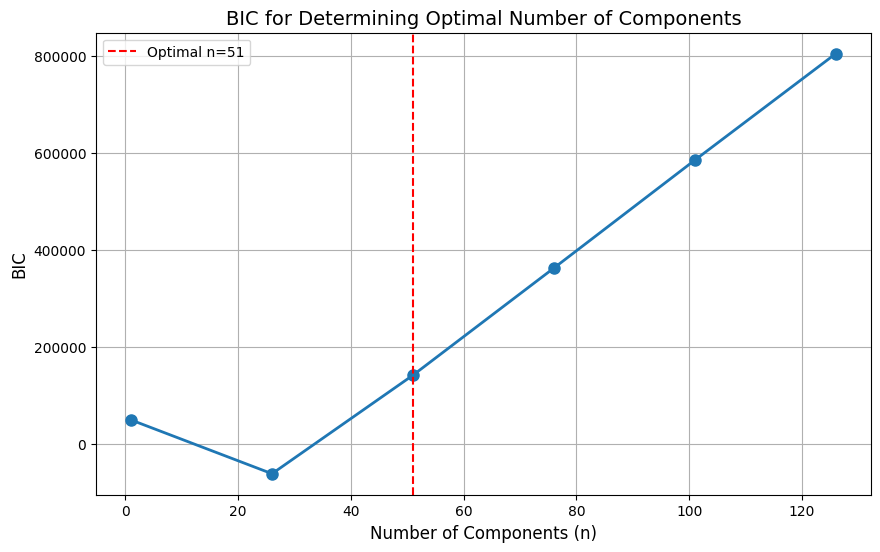


Selected n_components: 51 (validation accuracy: 1.0000)


In [9]:
# Try semi-supervised GMM with optimal covariance type
print("\nTraining semi-supervised GMM...")
semi_supervised_gmm = GaussianMixtureModel(
    max_iters=150,
    tol=1e-4,
    reg_covar=1e-4,
    covariance_type='full',
    init_method='kmeans++',
    semi_supervised=True,
    supervision_weight=0.8
)

# Find optimal components using smaller search range
n_range_ss = range(1, n_speakers*3 + 1, n_speakers//2)
optimal_n_ss, val_accuracy_ss, _ = find_optimal_components(
    semi_supervised_gmm, X_train_norm, X_val_norm, X_test_norm, y_train, y_val, y_test, n_range_ss, y_train_for_semi=y_train
)


In [10]:
# Train ensemble GMM
print("\nTraining ensemble GMM...")
ensemble_gmm = EnsembleGMM(
    n_estimators=5,
    max_iters=150,
    tol=1e-4,
    reg_covar=1e-4,
    covariance_types=['full', 'diagonal', 'tied'],
    semi_supervised=True,
    supervision_weight=0.8
)

# Train with optimal number of components
print(f"\nTraining with optimal n_components = {optimal_n_ss}...")
start_time = time.time()
ensemble_gmm.fit(X_train_norm, optimal_n_ss, y=y_train, n_init=3)
print(f"Training completed in {time.time() - start_time:.2f} seconds")





Training ensemble GMM...

Training with optimal n_components = 51...

Training ensemble member 1/5 with covariance_type='full'
Initialization 1/3
Converged after 5 iterations
Initialization 2/3
Converged after 7 iterations
Initialization 3/3
Converged after 7 iterations

Training ensemble member 2/5 with covariance_type='diagonal'
Initialization 1/3
Converged after 4 iterations
Initialization 2/3
Converged after 4 iterations
Initialization 3/3
Converged after 4 iterations

Training ensemble member 3/5 with covariance_type='tied'
Initialization 1/3
Converged after 56 iterations
Initialization 2/3
Converged after 27 iterations
Initialization 3/3
Converged after 14 iterations

Training ensemble member 4/5 with covariance_type='full'
Initialization 1/3
Converged after 6 iterations
Initialization 2/3
Converged after 6 iterations
Initialization 3/3
Converged after 6 iterations

Training ensemble member 5/5 with covariance_type='diagonal'
Initialization 1/3
Converged after 4 iterations
Initi

In [11]:
# Predict labels and evaluate
print("Evaluating on train/val/test sets...")
train_labels = ensemble_gmm.predict(X_train_norm)
val_labels = ensemble_gmm.predict(X_val_norm)
test_labels = ensemble_gmm.predict(X_test_norm)

# Map cluster labels to speaker IDs
mapped_train_labels = enhanced_map_clusters_to_speakers(train_labels, y_train)
mapped_val_labels = enhanced_map_clusters_to_speakers(val_labels, y_val)
mapped_test_labels = enhanced_map_clusters_to_speakers(test_labels, y_test)

# Calculate accuracies
train_accuracy = evaluate(y_train, mapped_train_labels)
val_accuracy = evaluate(y_val, mapped_val_labels)
test_accuracy = evaluate(y_test, mapped_test_labels)


Evaluating on train/val/test sets...
Average cluster purity: 0.9984
Average cluster purity: 1.0000
Average cluster purity: 0.9992


In [12]:
print("\nFinal Results:")
print(f"Number of Components: {optimal_n_ss}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Final Results:
Number of Components: 51
Training Accuracy: 0.9986
Validation Accuracy: 1.0000
Test Accuracy: 0.9987



Generating visualizations...
Plotting confusion matrix...


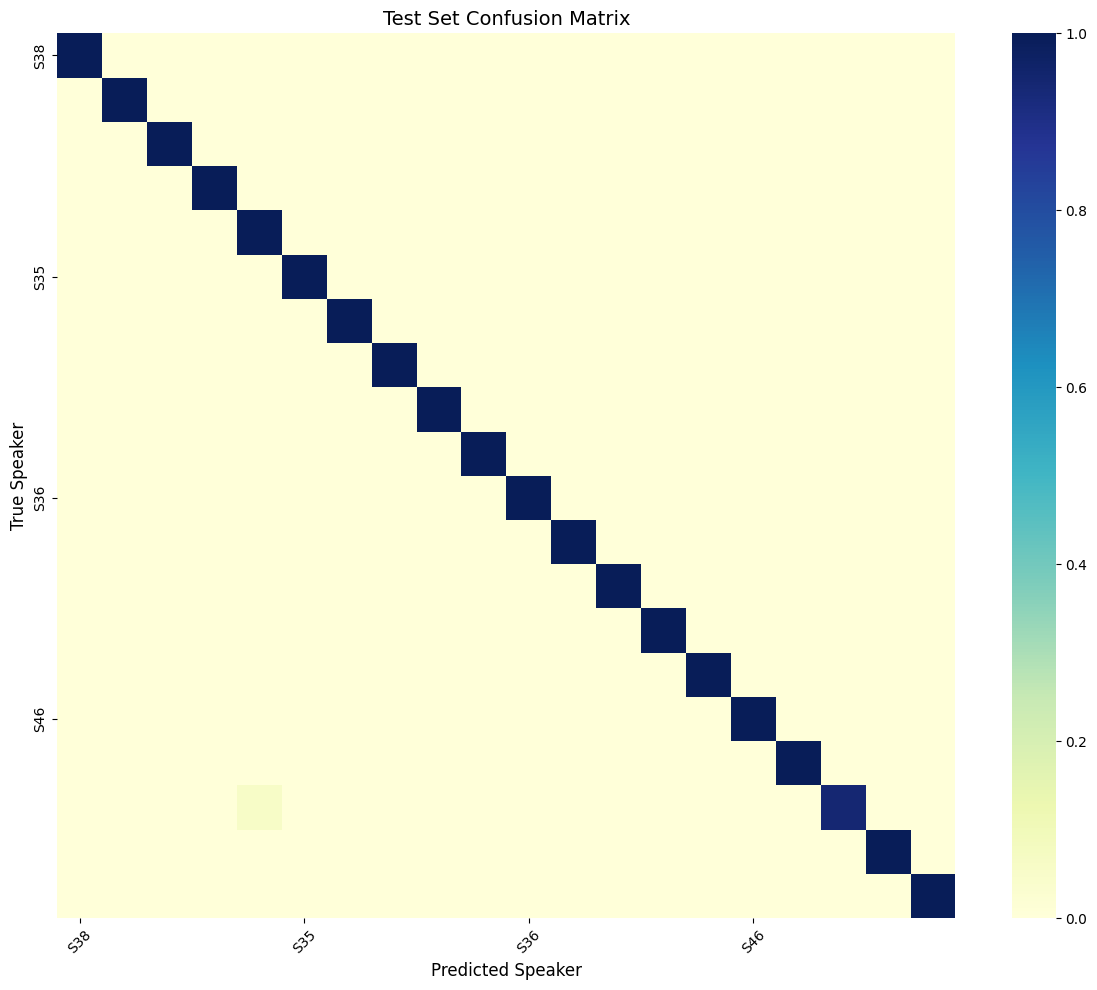

Plotting per-speaker accuracy...


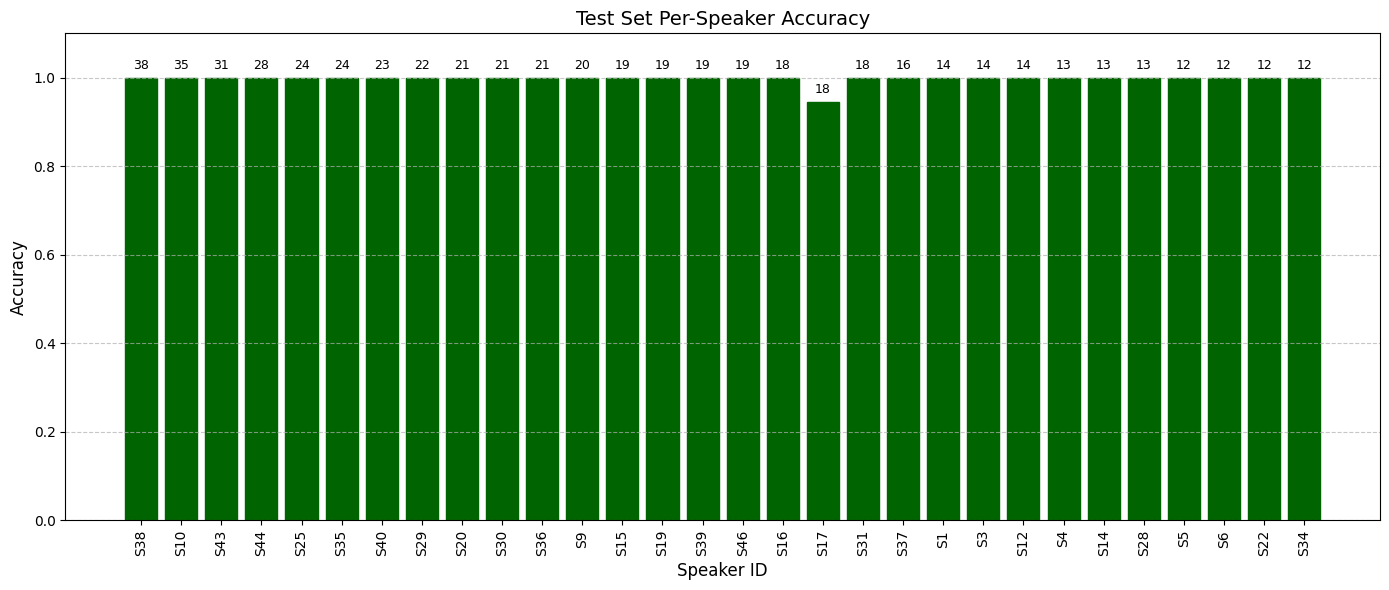

Analyzing cluster purity...


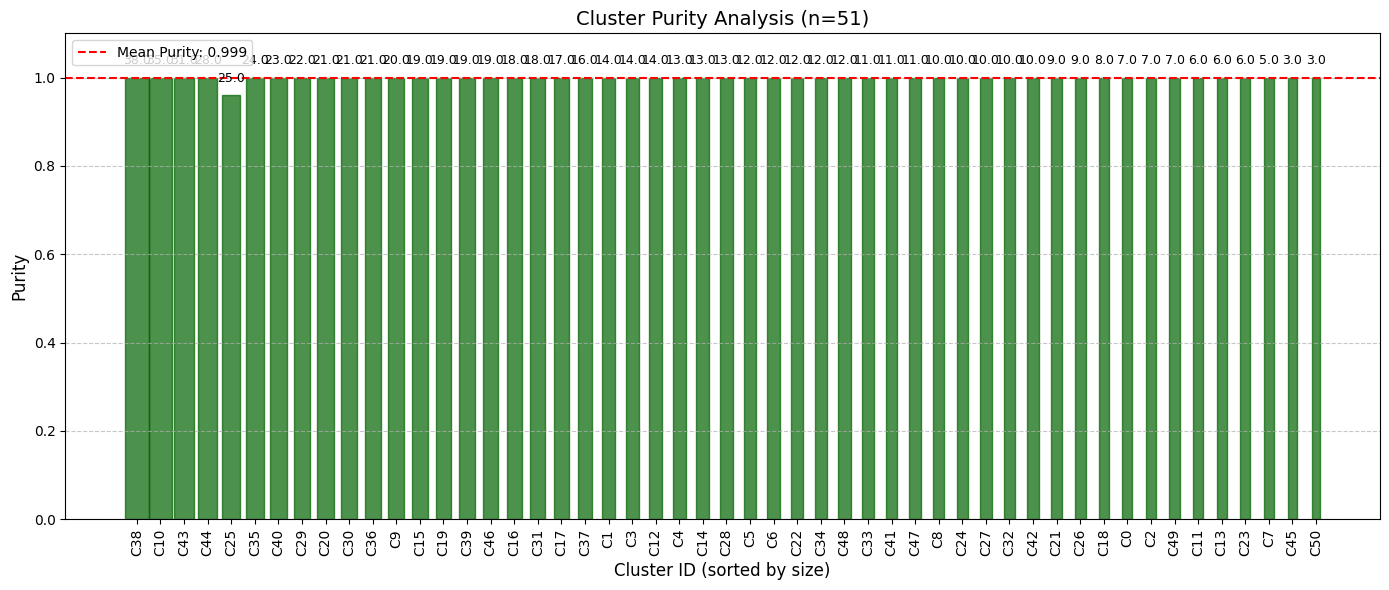

In [13]:
# Generate additional visualizations for better analysis
print("\nGenerating visualizations...")

# Plot confusion matrix
print("Plotting confusion matrix...")
plot_confusion_matrix(y_test, mapped_test_labels, title="Test Set Confusion Matrix")

# Plot per-speaker accuracy
print("Plotting per-speaker accuracy...")
plot_per_speaker_accuracy(y_test, mapped_test_labels, title="Test Set Per-Speaker Accuracy")

# Plot cluster purity
print("Analyzing cluster purity...")
cluster_purities, cluster_sizes, confusion = calculate_cluster_purity(test_labels, y_test)
plot_cluster_purity(cluster_purities, cluster_sizes, optimal_n_ss)



# Refactored implementation to compare GMM with different preprocessing techniques


In [14]:
# Define preprocessing function for different methods
def preprocess_data(X_train, X_val, X_test, method='none', pca_components=None):
    """
    Apply different preprocessing methods to the data
    
    Parameters:
    - method: 'none', 'pca', or 'lda'
    - pca_components: number of components for PCA
    """
    if method == 'pca':
        print(f"Applying PCA with {pca_components} components...")
        X_train_prep, X_val_prep, X_test_prep = advanced_preprocess(
            X_train, X_val, X_test, n_components=pca_components, use_power_transform=True
        )
        print(f"Data shape after PCA: {X_train_prep.shape}")
    elif method == 'lda':
        # Using provided LDA features directly
        print("Using provided LDA features...")
        X_train_prep, X_test_prep = normalize_features(X_train, X_test)
        _, X_val_prep = normalize_features(X_train, X_val)
        print(f"Data shape with LDA features: {X_train_prep.shape}")
    else:
        # No dimensionality reduction, just normalization
        print("Using original features with normalization...")
        X_train_prep, X_test_prep = normalize_features(X_train, X_test)
        _, X_val_prep = normalize_features(X_train, X_val)
        print(f"Data shape with original features: {X_train_prep.shape}")
        
    return X_train_prep, X_val_prep, X_test_prep



COMPARISON OF DIFFERENT GMM TECHNIQUES
Original data dimensionality: 49

Running GMM with PCA preprocessing
Applying PCA with 49 components...
PCA explained variance: 1.0000
Data shape after PCA: (1405, 49)

Finding optimal number of components for PCA-GMM...

Testing n_components = 25
Initialization 1/3
Converged after 5 iterations
Initialization 2/3
Converged after 4 iterations
Initialization 3/3
Converged after 5 iterations
BIC: -72957.55099544086
Average cluster purity: 0.7395
Average cluster purity: 0.7714
Average cluster purity: 0.7361
Training Accuracy: 0.6420
Validation Accuracy: 0.6591
Testing Accuracy: 0.6273
Time taken: 3.18 seconds


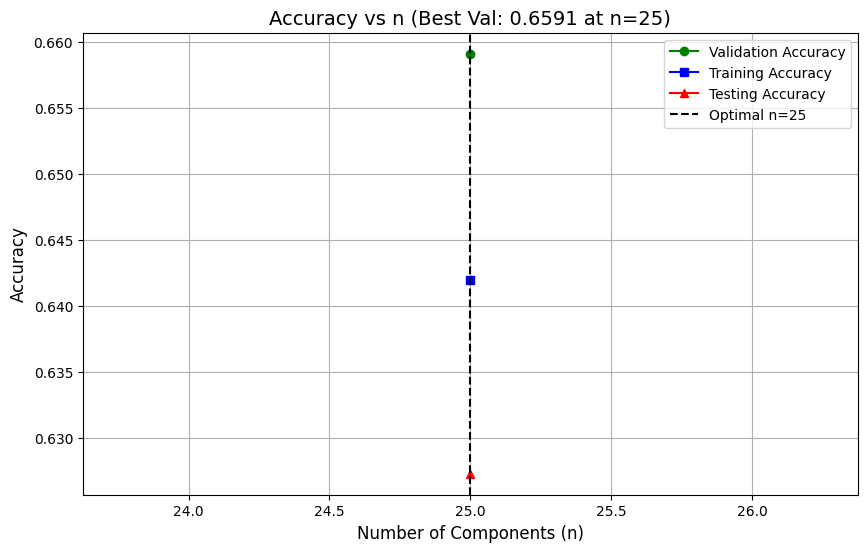

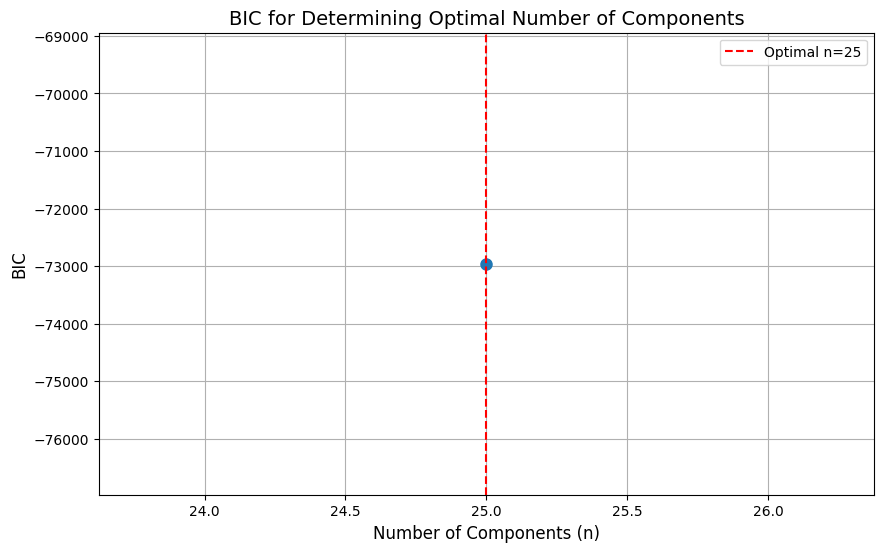


Selected n_components: 25 (validation accuracy: 0.6591)

Training GMM with 25 components...
Initialization 1/3
Converged after 5 iterations
Initialization 2/3
Converged after 5 iterations
Initialization 3/3
Converged after 4 iterations
Training completed in 2.68 seconds


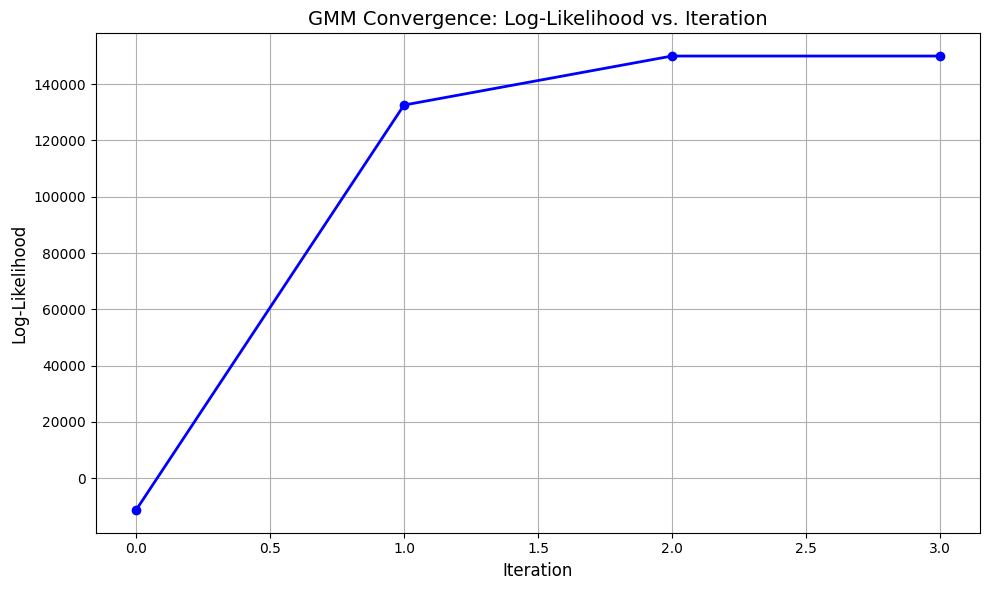


Evaluating PCA-GMM performance...
Average cluster purity: 0.7554
Average cluster purity: 0.7834
Average cluster purity: 0.7467

Results for PCA-GMM:
Number of Components: 25
Training Accuracy: 0.6335
Validation Accuracy: 0.6761
Test Accuracy: 0.6114

Generating visualizations for PCA-GMM...


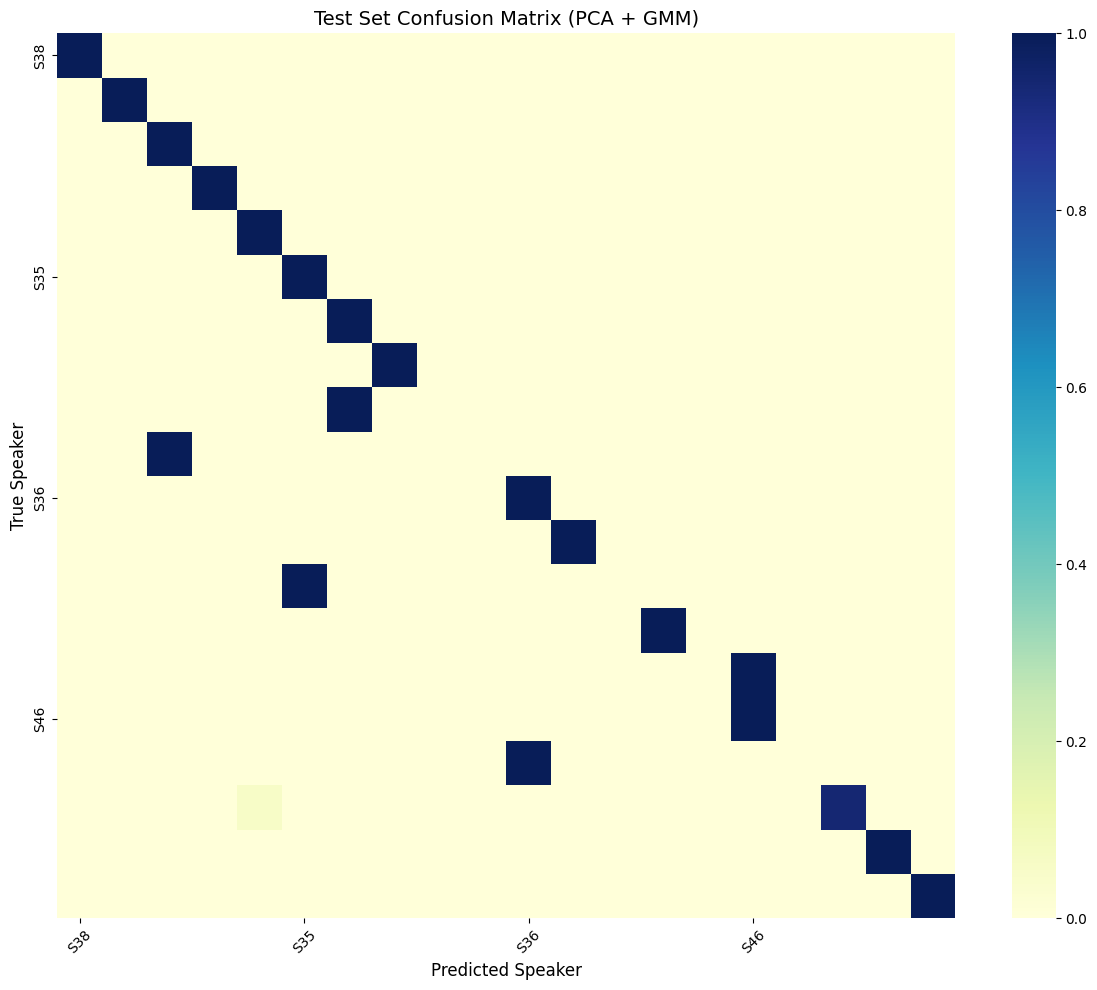

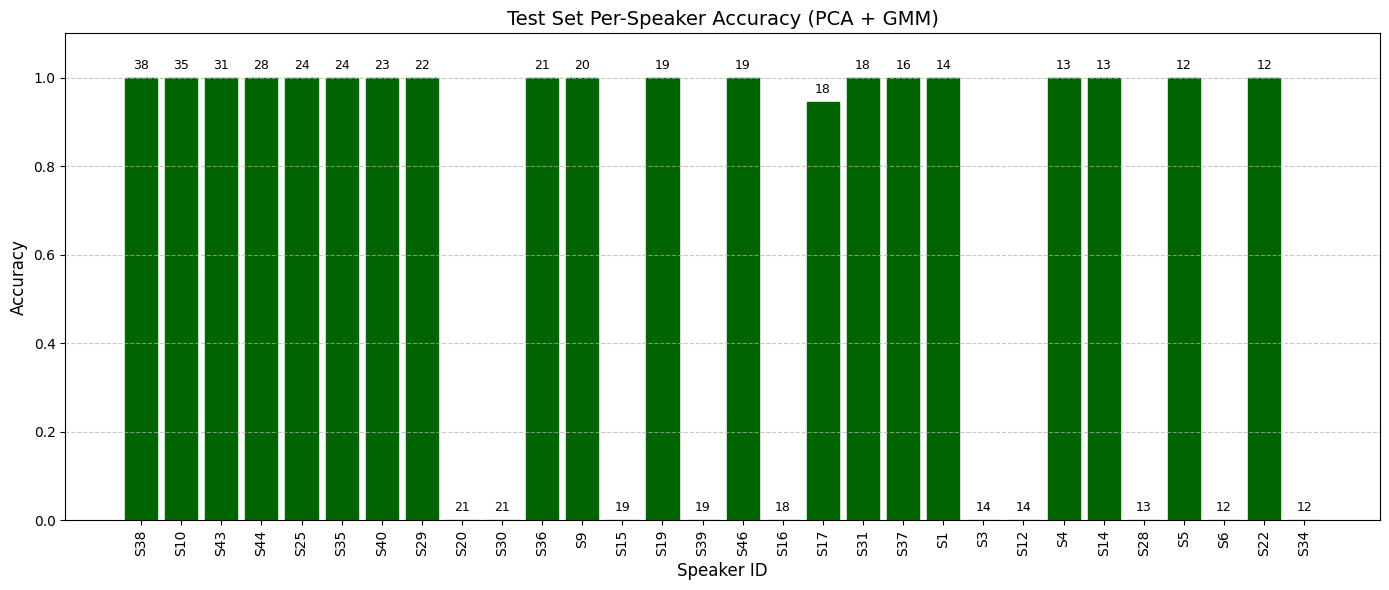

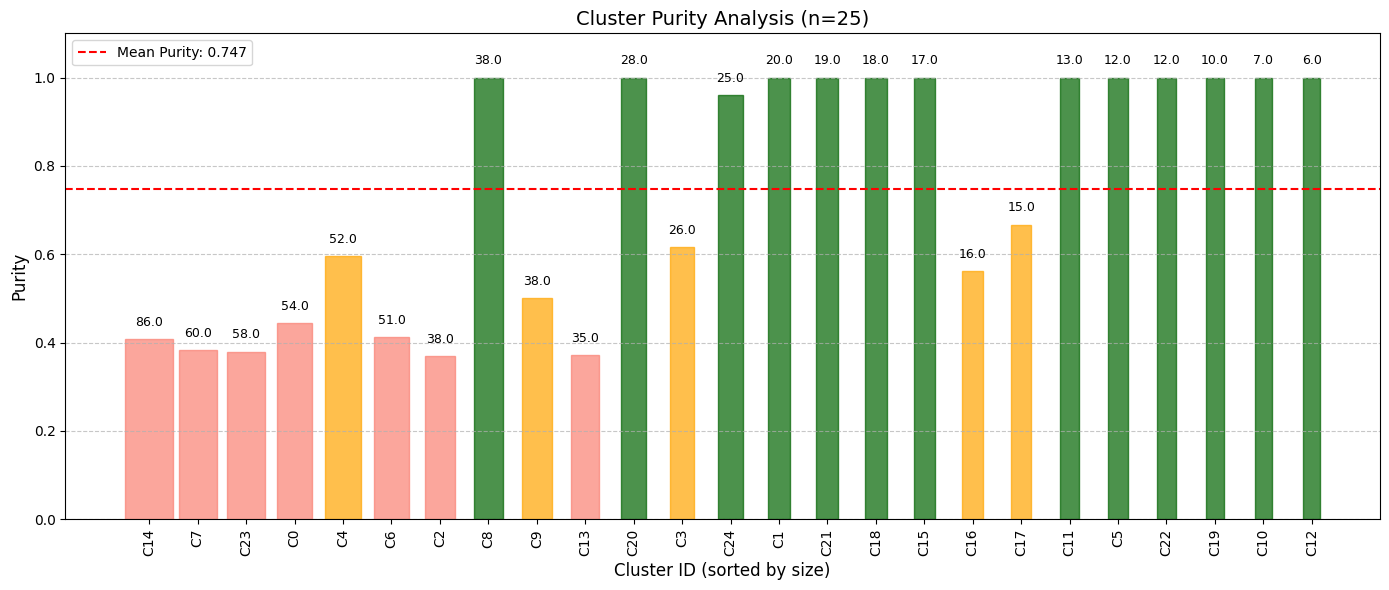

Applying t-SNE for visualization...


C:\Users\honpa\AppData\Local\Temp\ipykernel_33000\2667980485.py:244: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_clusters)


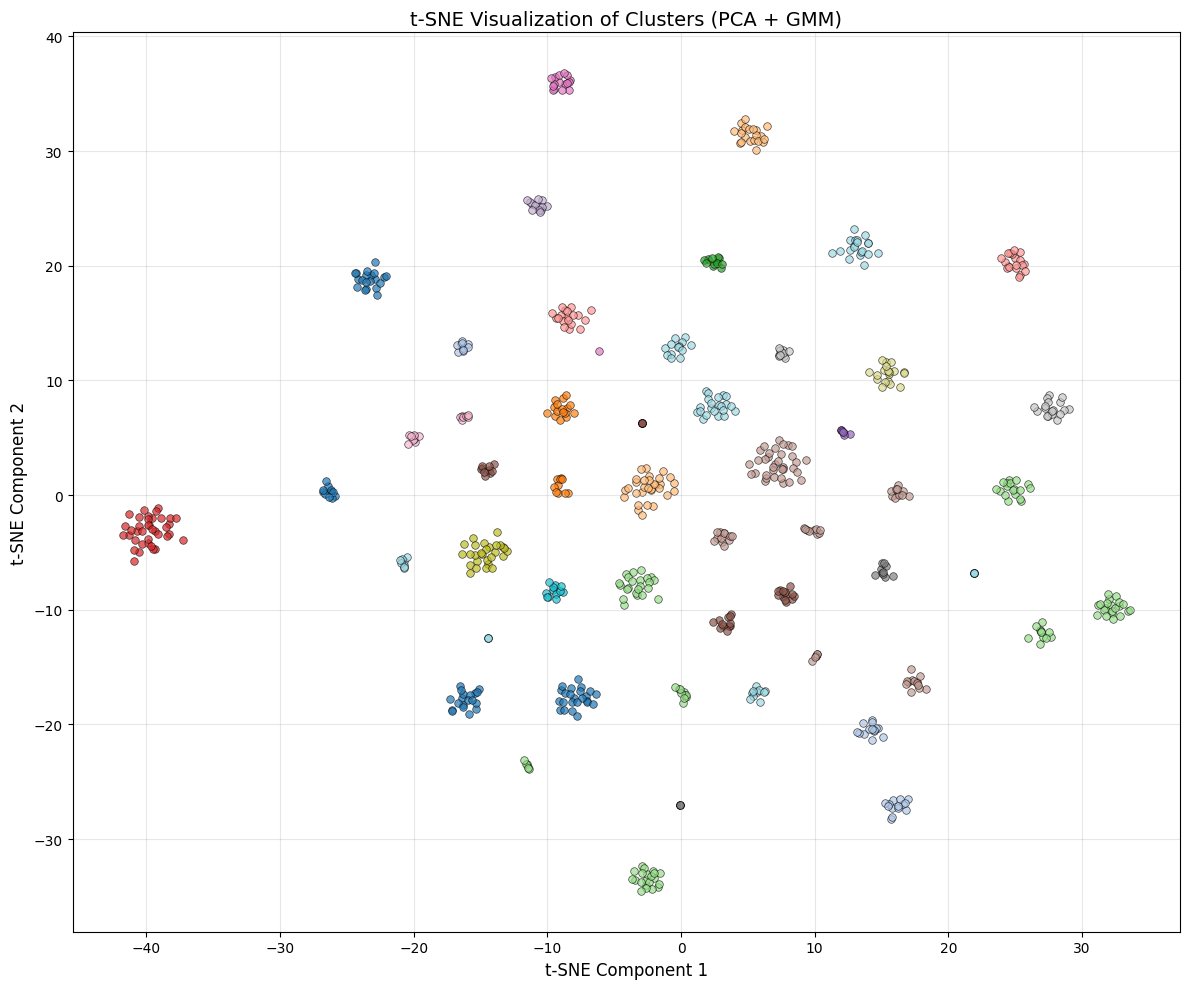


Running GMM with LDA preprocessing
Using provided LDA features...
Data shape with LDA features: (2511, 49)

Finding optimal number of components for LDA-GMM...

Testing n_components = 25
Initialization 1/3
Converged after 7 iterations
Initialization 2/3
Converged after 7 iterations
Initialization 3/3
Converged after 9 iterations
BIC: -275162.8658845674
Average cluster purity: 0.0978
Average cluster purity: 0.7535
Average cluster purity: 0.7700
Training Accuracy: 0.0641
Validation Accuracy: 0.6023
Testing Accuracy: 0.6154
Time taken: 5.30 seconds


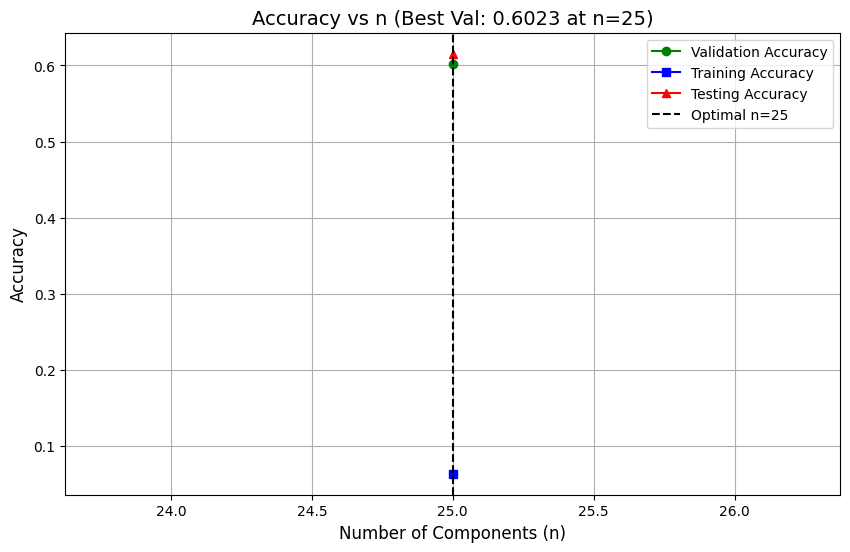

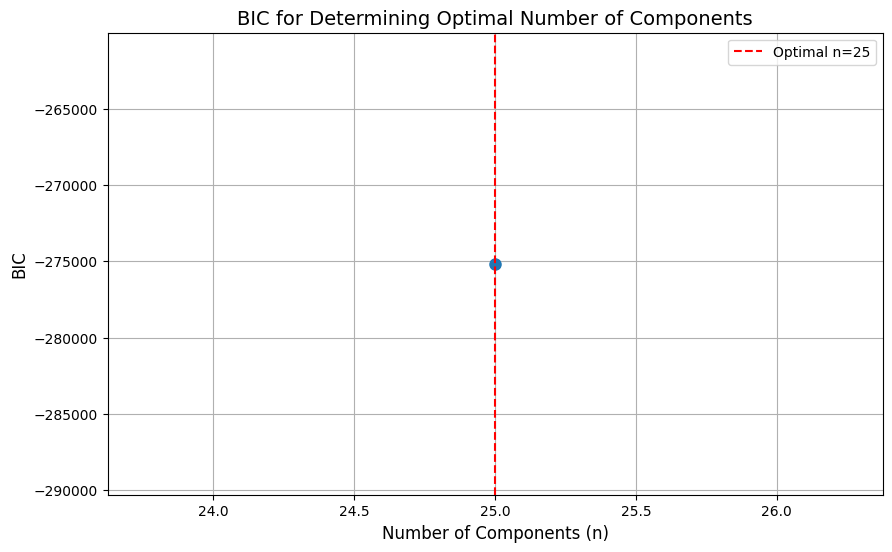


Selected n_components: 25 (validation accuracy: 0.6023)

Training GMM with 25 components...
Initialization 1/3
Converged after 8 iterations
Initialization 2/3
Converged after 6 iterations
Initialization 3/3
Converged after 7 iterations
Training completed in 5.14 seconds


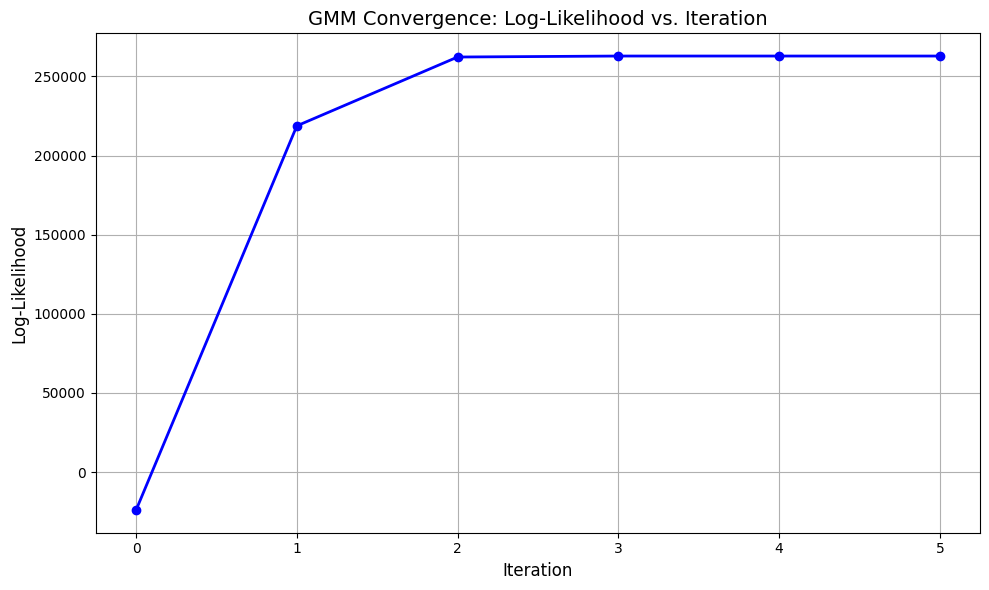


Evaluating LDA-GMM performance...
Average cluster purity: 0.1150
Average cluster purity: 0.7382
Average cluster purity: 0.7304

Results for LDA-GMM:
Number of Components: 25
Training Accuracy: 0.0669
Validation Accuracy: 0.6250
Test Accuracy: 0.5968

Generating visualizations for LDA-GMM...


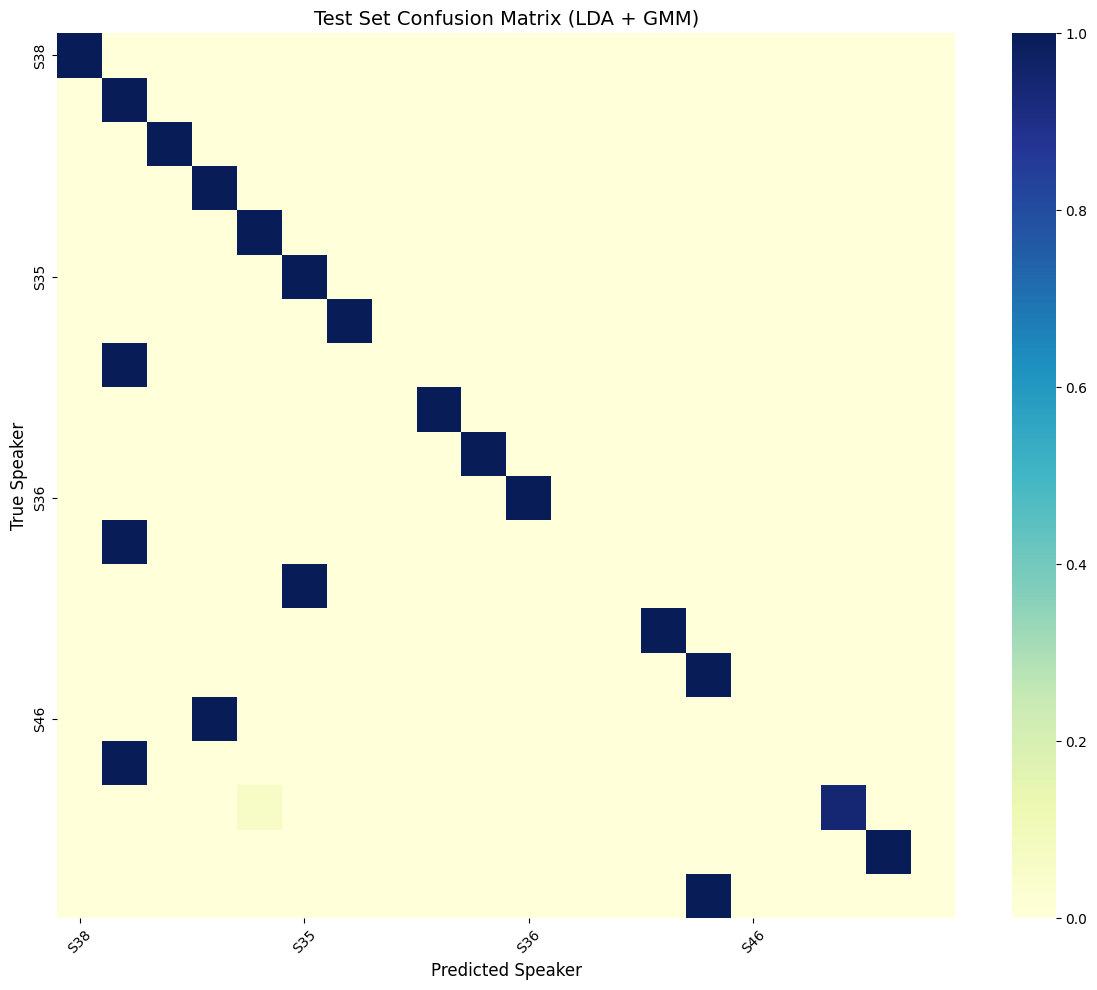

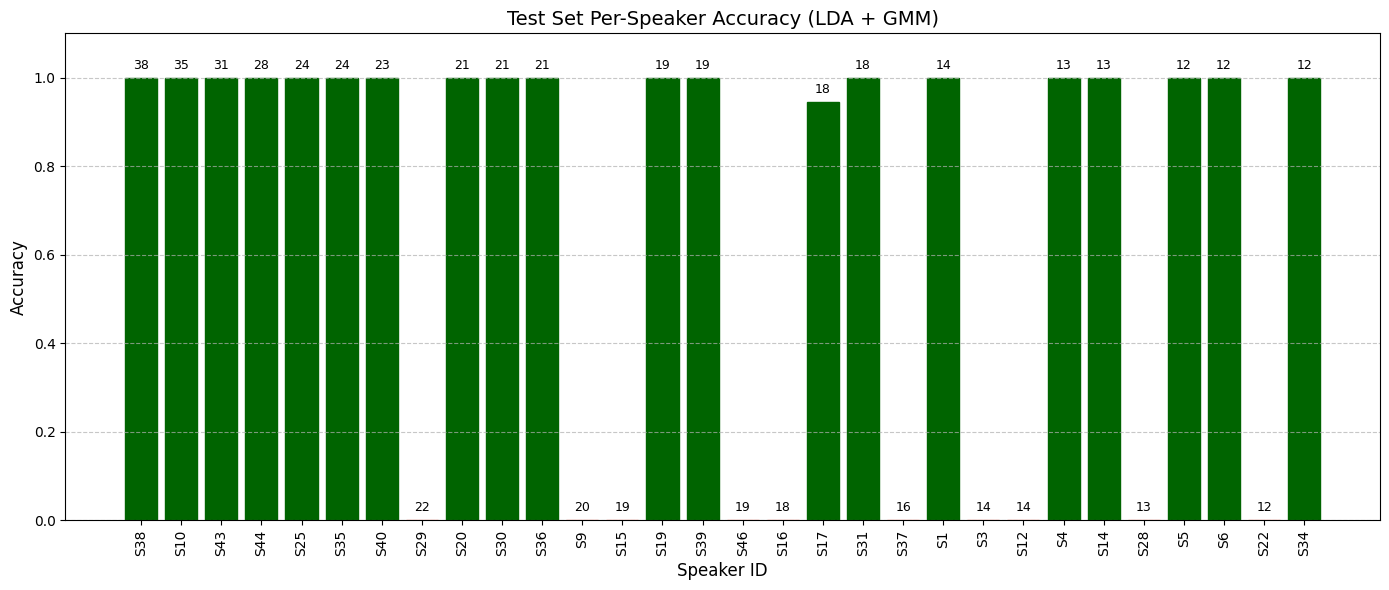

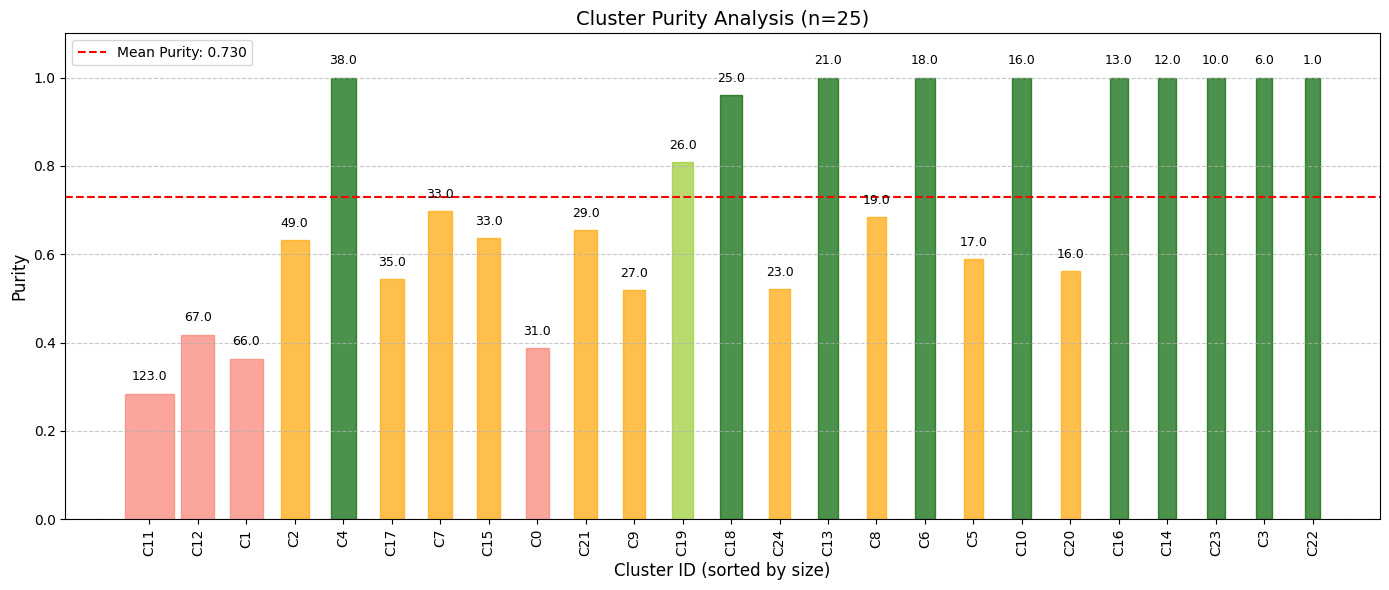

Applying t-SNE for visualization...


C:\Users\honpa\AppData\Local\Temp\ipykernel_33000\2667980485.py:244: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_clusters)


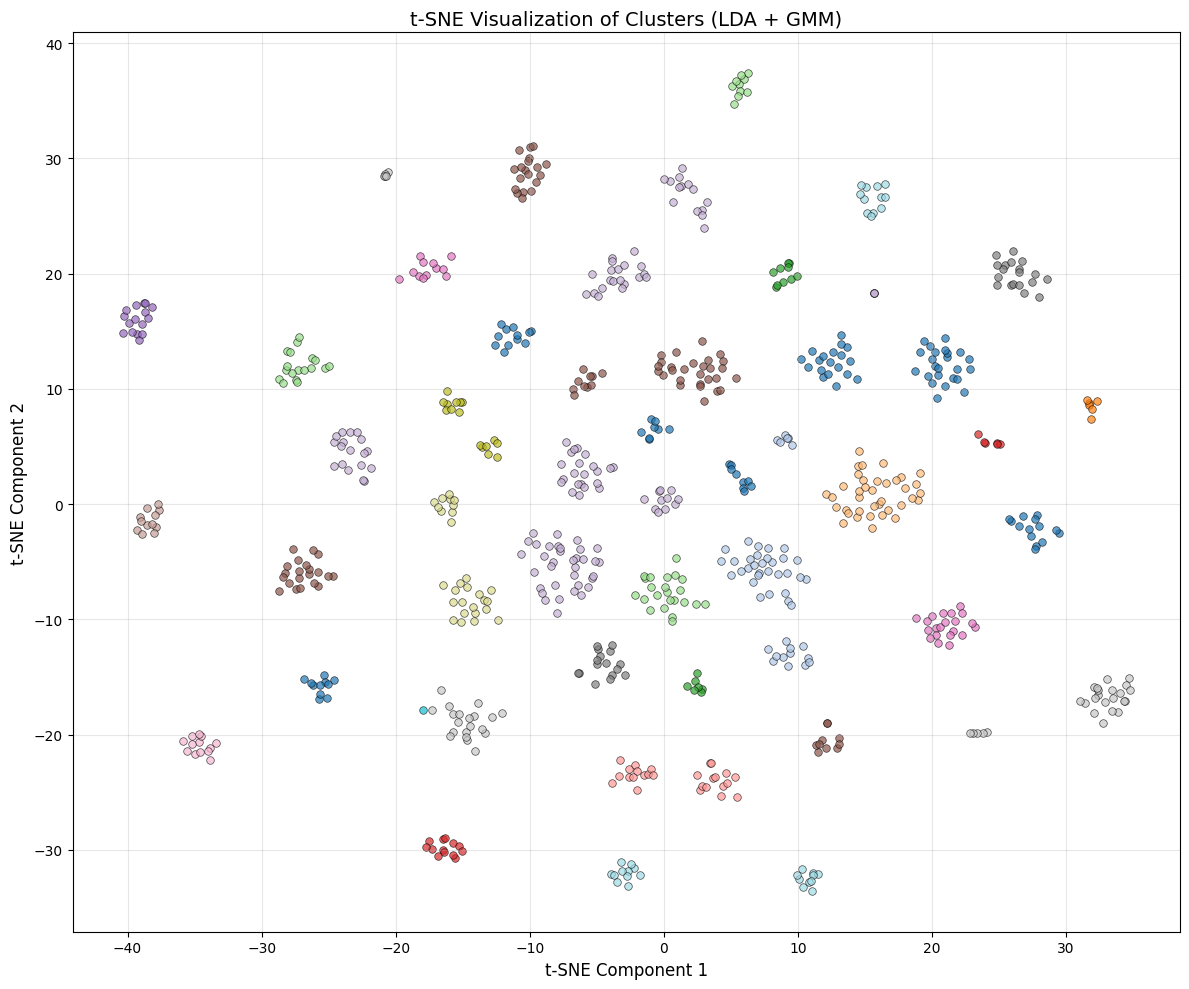

In [15]:
# Run experiments with different preprocessing methods
# Run experiments with different preprocessing methods
print("\n" + "="*80)
print("COMPARISON OF DIFFERENT GMM TECHNIQUES")
print("="*80)

# Original dimensionality of the data
orig_dim = X_train.shape[1]
print(f"Original data dimensionality: {orig_dim}")

# Define PCA components to use
pca_components = min(orig_dim, 50)  # Use 50 components or less if original dim is smaller

# Define range of components to test
n_range_standard = range(max(3, n_speakers//2), min(n_speakers*2, 30), max(1, n_speakers//10))

# Store results for comparison
all_results = []

# 1. Run GMM with PCA preprocessing
print(f"\n{'='*60}")
print(f"Running GMM with PCA preprocessing")
print(f"{'='*60}")

# Preprocess data with PCA
X_train_pca, X_val_pca, X_test_pca = preprocess_data(
    X_train, X_val, X_test, method='pca', pca_components=pca_components
)

# Create standard GMM model
gmm_pca = GaussianMixtureModel(
    max_iters=150,
    tol=1e-4,
    reg_covar=1e-4,
    covariance_type='full',
    init_method='kmeans++',
    semi_supervised=False
)

# Find optimal number of components
print("\nFinding optimal number of components for PCA-GMM...")
optimal_n_pca, val_accuracy_pca, bic_values_pca = find_optimal_components(
    gmm_pca, X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test, n_range_standard
)

# Train with optimal number of components
print(f"\nTraining GMM with {optimal_n_pca} components...")
start_time = time.time()
labels_pca, log_likelihoods_pca = gmm_pca.fit(X_train_pca, optimal_n_pca, n_init=3)
train_time_pca = time.time() - start_time
print(f"Training completed in {train_time_pca:.2f} seconds")

# Plot likelihood convergence
plot_likelihood_convergence(log_likelihoods_pca)

# Predict and evaluate
print("\nEvaluating PCA-GMM performance...")
train_labels_pca = gmm_pca.predict(X_train_pca)
val_labels_pca = gmm_pca.predict(X_val_pca)
test_labels_pca = gmm_pca.predict(X_test_pca)

# Map cluster labels to speaker IDs
mapped_train_labels_pca = enhanced_map_clusters_to_speakers(train_labels_pca, y_train)
mapped_val_labels_pca = enhanced_map_clusters_to_speakers(val_labels_pca, y_val)
mapped_test_labels_pca = enhanced_map_clusters_to_speakers(test_labels_pca, y_test)

# Calculate accuracies
train_accuracy_pca = evaluate(y_train, mapped_train_labels_pca)
val_accuracy_pca = evaluate(y_val, mapped_val_labels_pca)
test_accuracy_pca = evaluate(y_test, mapped_test_labels_pca)

print("\nResults for PCA-GMM:")
print(f"Number of Components: {optimal_n_pca}")
print(f"Training Accuracy: {train_accuracy_pca:.4f}")
print(f"Validation Accuracy: {val_accuracy_pca:.4f}")
print(f"Test Accuracy: {test_accuracy_pca:.4f}")

# Store results
results_pca = {
    'preprocessing': 'PCA + GMM',
    'n_components': optimal_n_pca,
    'train_accuracy': train_accuracy_pca,
    'val_accuracy': val_accuracy_pca,
    'test_accuracy': test_accuracy_pca,
    'training_time': train_time_pca
}
all_results.append(results_pca)

# Generate visualizations
print("\nGenerating visualizations for PCA-GMM...")
plot_confusion_matrix(y_test, mapped_test_labels_pca, title="Test Set Confusion Matrix (PCA + GMM)")
plot_per_speaker_accuracy(y_test, mapped_test_labels_pca, title="Test Set Per-Speaker Accuracy (PCA + GMM)")
cluster_purities_pca, cluster_sizes_pca, confusion_pca = calculate_cluster_purity(test_labels_pca, y_test)
plot_cluster_purity(cluster_purities_pca, cluster_sizes_pca, optimal_n_pca)

# Visualize embeddings
if X_test_pca.shape[0] > 5000:
    indices = np.random.choice(X_test_pca.shape[0], 5000, replace=False)
    X_subset = X_test_pca[indices]
    labels_subset = test_labels_pca[indices]
    true_subset = y_test[indices]
else:
    X_subset = X_test_pca
    labels_subset = test_labels_pca
    true_subset = y_test
    
plot_cluster_embeddings(X_subset, labels_subset, method='tsne',
                       title="t-SNE Visualization of Clusters (PCA + GMM)")
                       

# 2. Run GMM with LDA preprocessing
print(f"\n{'='*60}")
print(f"Running GMM with LDA preprocessing")
print(f"{'='*60}")

# Preprocess data with LDA (using the provided LDA features)
X_train_lda, X_val_lda, X_test_lda = preprocess_data(
    X_lda, X_val, X_test, method='lda'
)

# Create standard GMM model
gmm_lda = GaussianMixtureModel(
    max_iters=150,
    tol=1e-4,
    reg_covar=1e-4,
    covariance_type='full',
    init_method='kmeans++',
    semi_supervised=False
)

# Find optimal number of components
print("\nFinding optimal number of components for LDA-GMM...")
optimal_n_lda, val_accuracy_lda, bic_values_lda = find_optimal_components(
    gmm_lda, X_train_lda, X_val_lda, X_test_lda, y_train, y_val, y_test, n_range_standard
)

# Train with optimal number of components
print(f"\nTraining GMM with {optimal_n_lda} components...")
start_time = time.time()
labels_lda, log_likelihoods_lda = gmm_lda.fit(X_train_lda, optimal_n_lda, n_init=3)
train_time_lda = time.time() - start_time
print(f"Training completed in {train_time_lda:.2f} seconds")

# Plot likelihood convergence
plot_likelihood_convergence(log_likelihoods_lda)

# Predict and evaluate
print("\nEvaluating LDA-GMM performance...")
train_labels_lda = gmm_lda.predict(X_train_lda)
val_labels_lda = gmm_lda.predict(X_val_lda)
test_labels_lda = gmm_lda.predict(X_test_lda)

# Map cluster labels to speaker IDs
mapped_train_labels_lda = enhanced_map_clusters_to_speakers(train_labels_lda, y_train)
mapped_val_labels_lda = enhanced_map_clusters_to_speakers(val_labels_lda, y_val)
mapped_test_labels_lda = enhanced_map_clusters_to_speakers(test_labels_lda, y_test)

# Calculate accuracies
train_accuracy_lda = evaluate(y_train, mapped_train_labels_lda)
val_accuracy_lda = evaluate(y_val, mapped_val_labels_lda)
test_accuracy_lda = evaluate(y_test, mapped_test_labels_lda)

print("\nResults for LDA-GMM:")
print(f"Number of Components: {optimal_n_lda}")
print(f"Training Accuracy: {train_accuracy_lda:.4f}")
print(f"Validation Accuracy: {val_accuracy_lda:.4f}")
print(f"Test Accuracy: {test_accuracy_lda:.4f}")

# Store results
results_lda = {
    'preprocessing': 'LDA + GMM',
    'n_components': optimal_n_lda,
    'train_accuracy': train_accuracy_lda,
    'val_accuracy': val_accuracy_lda,
    'test_accuracy': test_accuracy_lda,
    'training_time': train_time_lda
}
all_results.append(results_lda)

# Generate visualizations
print("\nGenerating visualizations for LDA-GMM...")
plot_confusion_matrix(y_test, mapped_test_labels_lda, title="Test Set Confusion Matrix (LDA + GMM)")
plot_per_speaker_accuracy(y_test, mapped_test_labels_lda, title="Test Set Per-Speaker Accuracy (LDA + GMM)")
cluster_purities_lda, cluster_sizes_lda, confusion_lda = calculate_cluster_purity(test_labels_lda, y_test)
plot_cluster_purity(cluster_purities_lda, cluster_sizes_lda, optimal_n_lda)

# Visualize embeddings
if X_test_lda.shape[0] > 5000:
    indices = np.random.choice(X_test_lda.shape[0], 5000, replace=False)
    X_subset = X_test_lda[indices]
    labels_subset = test_labels_lda[indices]
    true_subset = y_test[indices]
else:
    X_subset = X_test_lda
    labels_subset = test_labels_lda
    true_subset = y_test
    
plot_cluster_embeddings(X_subset, labels_subset, method='tsne',
                       title="t-SNE Visualization of Clusters (LDA + GMM)")

# 3. Add results from semi-supervised GMM to the comparison
all_results.append({
    'preprocessing': 'Semi-supervised GMM',
    'n_components': optimal_n_ss,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'training_time': None  # Not measured for this method
})


COMPARISON OF DIFFERENT TECHNIQUES

Accuracy Comparison:
--------------------------------------------------------------------------------
Method                    Components   Train Acc    Val Acc      Test Acc    
--------------------------------------------------------------------------------
PCA + GMM                 25           0.6335       0.6761       0.6114      
LDA + GMM                 25           0.0669       0.6250       0.5968      
Semi-supervised GMM       51           0.9986       1.0000       0.9987      
--------------------------------------------------------------------------------


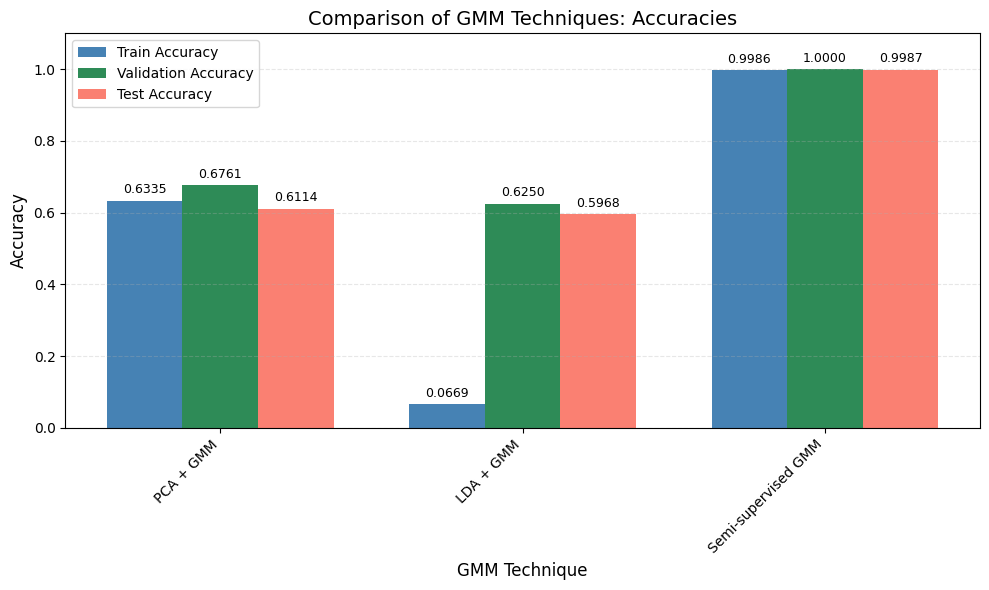

In [16]:
# Compare results of different techniques
print("\n" + "="*80)
print("COMPARISON OF DIFFERENT TECHNIQUES")
print("="*80)

# Create comparison table
print("\nAccuracy Comparison:")
print("-"*80)
print(f"{'Method':<25} {'Components':<12} {'Train Acc':<12} {'Val Acc':<12} {'Test Acc':<12}")
print("-"*80)

for result in all_results:
    method = result['preprocessing']
    n_comp = result['n_components']
    train_acc = result['train_accuracy']
    val_acc = result['val_accuracy']
    test_acc = result['test_accuracy']
    
    print(f"{method:<25} {n_comp:<12} {train_acc:<12.4f} {val_acc:<12.4f} {test_acc:<12.4f}")

print("-"*80)

# Plot comparison of test accuracies
methods = [r['preprocessing'] for r in all_results]
train_accs = [r['train_accuracy'] for r in all_results]
val_accs = [r['val_accuracy'] for r in all_results]
test_accs = [r['test_accuracy'] for r in all_results]

x = np.arange(len(methods))  # label locations
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, train_accs, width, label='Train Accuracy', color='steelblue')
plt.bar(x, val_accs, width, label='Validation Accuracy', color='seagreen')
plt.bar(x + width, test_accs, width, label='Test Accuracy', color='salmon')

plt.xlabel('GMM Technique', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of GMM Techniques: Accuracies', fontsize=14)
plt.xticks(x, methods, rotation=45, ha='right')
plt.ylim(0, 1.1)

# Annotate accuracy values on top of each bar
for i in range(len(methods)):
    plt.text(x[i] - width, train_accs[i] + 0.02, f"{train_accs[i]:.4f}", ha='center', fontsize=9)
    plt.text(x[i], val_accs[i] + 0.02, f"{val_accs[i]:.4f}", ha='center', fontsize=9)
    plt.text(x[i] + width, test_accs[i] + 0.02, f"{test_accs[i]:.4f}", ha='center', fontsize=9)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()